In [1]:
import pandas as pd
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
np.random.seed(2020)
from gensim import corpora, models
import tensorflow as tf
from gensim.summarization.summarizer import summarize
from nltk import FreqDist, word_tokenize
import datetime, string
import tqdm, spacy
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('news_dataset.csv').set_index('id')


In [3]:
df.shape

(141585, 8)

In [4]:
article_df = df[['title','content']]

In [5]:
stemmer = PorterStemmer()

# Preprocessing of data

In [6]:
def set_text_lower(text): return text.lower()

def remove_punctuation(text):
    text_p = "".join([char for char in text if char not in string.punctuation])
    
    
def tokenization(text):
    words = word_tokenize(text)
    
def stemmer(text):
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in filtered_words]

    

# To do:
Compare results between PorterStemmer, SnowballStemmer and spacy lemmatizer

In [7]:
# obj = SnowballStemmer(language='english')
obj = PorterStemmer()

obj.stem('breath')

'breath'

# Following the tutorial from: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [8]:
def lemmatize_stemming(text):
#     return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    return obj.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
#     return obj.stem(text)


def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3: # we remove stopwords and words with less than 3 characters
            result.append(lemmatize_stemming(token))
    return result

In [9]:
df["content"].head()

id
1    WASHINGTON  —   Congressional Republicans have...
2    After the bullet shells get counted, the blood...
3    When Walt Disney’s “Bambi” opened in 1942, cri...
4    Death may be the great equalizer, but it isn’t...
5    SEOUL, South Korea  —   North Korea’s leader, ...
Name: content, dtype: object

In [10]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


# def sent_to_words(sentence):
#     try:
#         sentence = re.sub('\S*@\S*\s?', '', sentence)  # remove emails
#         sentence = re.sub('\s+', ' ', sentence)  # remove newline chars
#         sentence = re.sub("\'", "", sentence)  # remove single quotes
#         sentence = gensim.utils.simple_preprocess(str(sentence), deacc=True) 
#         return sentence 
#     except:
#         return sentence 
    
# df["content"] = df["content"].map(lambda x:sent_to_words(x))

def sent_to_words(sentences):
    for sent in sentences:
        try:
            sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
            sent = re.sub('\s+', ' ', sent)  # remove newline chars
            sent = re.sub("\'", "", sent)  # remove single quotes
            sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
            yield(sent)  
        except:
            pass 

# Convert to list
data = df["content"].sample(n=10000, random_state=2020).values.tolist()
# data = df.content.iloc[:10000].values.tolist()
# data = df.content.values.tolist()
data_words = list(sent_to_words(data))

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [11]:
# df.to_pickle("df_s2w_1.pkl")
# df = pd.read_pickle("df_s2w.pkl")

In [11]:
processed_docs = article_df['content'].iloc[:100].map(preprocess)

# dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary = gensim.corpora.Dictionary(data_ready)
# count = 0
# for k, v in dictionary.iteritems():
#     print(k, v)
#     count += 1
#     if count > 10:
#         break
# dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in data_ready]

In [12]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# from pprint import pprint
# for doc in corpus_tfidf:
#     pprint(doc)
#     break

In [13]:
# gensim.corpora.mmcorpus.MmCorpus.serialize(fname='corpus_tfidf_full.saved' ,corpus=corpus_tfidf)

LDA trained using bag of words

In [40]:
lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=20, id2word=dictionary, passes=10, workers=6)

In [41]:
lda_model_bow.save('lda_model_bow_10000_20.saved')

LDA trained using term frequency - inverse document frequency

In [42]:
for index, score in sorted(lda_model_bow[bow_corpus[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_bow.print_topic(index, 10)))


Score: 0.74144047498703	 
Topic: 0.021*"woman" + 0.007*"people" + 0.006*"email" + 0.005*"campaign" + 0.005*"work" + 0.005*"report" + 0.005*"tell" + 0.004*"time" + 0.004*"question" + 0.004*"ask"

Score: 0.19124190509319305	 
Topic: 0.018*"police" + 0.011*"officer" + 0.008*"man" + 0.008*"tell" + 0.008*"people" + 0.007*"report" + 0.007*"kill" + 0.006*"case" + 0.005*"accord" + 0.005*"shoot"

Score: 0.05180966109037399	 
Topic: 0.012*"black" + 0.011*"show" + 0.010*"season" + 0.008*"people" + 0.006*"white" + 0.005*"man" + 0.004*"time" + 0.004*"episode" + 0.004*"character" + 0.004*"well"


In [43]:
article_df.iloc[0].content

'WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge sums to temporarily prop up the Obama health care law, angering conservative voters who have been 

In [44]:
summarize(article_df.iloc[0].content)

'The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues.\nCollyer ruled that House Republicans had the standing to sue the executive branch over a spending dispute and that the Obama administration had been distributing the health insurance subsidies, in violation of the Constitution, without approval from Congress.\nAnticipating that the Trump administration might not be inclined to mount a vigorous fight against the House Republicans given the  ’s dim view of the health care law, a team of lawyers this month sought to intervene in the case on behalf of two participants in the health care program.\n” No matter what happens, House Republicans say, they want to prevail on two overarching concepts: the congressional power of the purse, and the right of Congr

In [45]:
simple_freq = FreqDist(article_df.iloc[1].content.split(' '))
print(sorted(simple_freq, reverse=True))

['”', '“”', '“ticket', '“they', '“then', '“slap”', '“get', '“don’t', '“because', '“Why', '“Whenever', '“When', '“We', '“There’s', '“The', '“That', '“Some', '“So', '“Please', '“Not', '“No', '“I’m', '“It’s', '“It', '“If', '“I', '“Here,', '“Both', '“Any', '“And', '“40th', '“', '—', 'you’re', 'your', 'young', 'you.', 'you,”', 'you,', 'you', 'yet', 'yellow', 'year’s', 'years.', 'years,', 'years', 'year.', 'year,', 'year', 'wrote,', 'wrote', 'write', 'wounded', 'would', 'worsened.', 'worse', 'worry', 'workload', 'working', 'worker', 'worked', 'work,', 'work', 'wooden', 'won’t', 'woman’s', 'witnesses', 'witness', 'without', 'with', 'wish', 'wired', 'windows', 'window.', 'win', 'wilted', 'will', 'wife,', 'wife', 'why', 'whom', 'whole,', 'who', 'whiter', 'while', 'which', 'where', 'whenever', 'when', 'wheel', 'what', 'we’re', 'were', 'went', 'well,', 'well', 'weeks', 'week', 'weed', 'weapon.', 'wealthier', 'we', 'way', 'wave', 'watched', 'watch', 'was', 'warped', 'warned', 'ward', 'wanted,', 'w

In [46]:
print(len('The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues.\nCollyer ruled that House Republicans had the standing to sue the executive branch over a spending dispute and that the Obama administration had been distributing the health insurance subsidies, in violation of the Constitution, without approval from Congress.\nAnticipating that the Trump administration might not be inclined to mount a vigorous fight against the House Republicans given the  ’s dim view of the health care law, a team of lawyers this month sought to intervene in the case on behalf of two participants in the health care program.\n” No matter what happens, House Republicans say, they want to prevail on two overarching concepts: the congressional power of the purse, and the right of Congress to sue the executive branch if it violates the Constitution regarding that spending power.\nJust as important to House Republicans, Judge Collyer found that Congress had the standing to sue the White House on this issue  —   a ruling that many legal experts said was flawed  —   and they want that precedent to be set to restore congressional leverage over the executive branch.\nBut on spending power and standing, the Trump administration may come under pressure from advocates of presidential authority to fight the House no matter their shared views on health care, since those precedents could have broad repercussions.'.split(' ')))

265


In [47]:
len(article_df.iloc[0].content.split(' '))

920

#### Trivial comparison:
#### Using SnowballStemmer, for LDA trained using BOW we obtain:
#### Score: 0.5481327772140503	 
#### Topic: 0.022*"health" + 0.015*"care" + 0.012*"insur" + 0.010*"republican" + 0.007*"plan" + 0.006*"repeal" + 0.006*"afford" + 0.006*"congress" + 0.005*"energi" + 0.005*"price"

#### LDA's main role is to help humans or other algorithms into understanding main concepts in large amounts of text

Starting from the result obtained previously we would say that the summarize of the first article is something related on (without reading previously the article, so we do not have any insight):
    
    Obama administration insurance plan, maybe a comparison between the obama administration (democrats) vs republican administration, it cannot afford (we have the word repeal which denotes some negation and afford) because of the price and energy

We can see that it can really help extracting the most important information out of a text.

Comparing with summarization done with gensim which doesn't do a really great job at extracting the essence of a text:
 - The original text had 920 words (all groups of chars split on whitespace)
 - The output of the summary had 265 words

   * The summary looks like this:
    
    The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues.
    Collyer ruled that House Republicans had the standing to sue the executive branch over a spending dispute and that the Obama administration had been distributing the health insurance subsidies, in violation of the Constitution, without approval from Congress.
    Anticipating that the Trump administration might not be inclined to mount a vigorous fight against the House Republicans given the  ’s dim view of the health care law, a team of lawyers this month sought to intervene in the case on behalf of two participants in the health care program.
    ” No matter what happens, House Republicans say, they want to prevail on two overarching concepts: the congressional power of the purse, and the right of Congress to sue the executive branch if it violates the Constitution regarding that spending power.
    Just as important to House Republicans, Judge Collyer found that Congress had the standing to sue the White House on this issue  —   a ruling that many legal experts said was flawed  —   and they want that precedent to be set to restore congressional leverage over the executive branch.
    But on spending power and standing, the Trump administration may come under pressure from advocates of presidential authority to fight the House no matter their shared views on health care, since those precedents could have broad repercussions.


Code from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#3.-Tokenize-Sentences-and-Clean

In [48]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_bow, corpus=bow_corpus
                                                  , texts=processed_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.7415,"woman, people, email, campaign, work, report, tell, time, question, ask",NaN
1,1,19.0,0.4884,"trump, campaign, people, election, vote, candidate, political, voter, time, support","[washington, congression, republican, fear, come, health, care, lawsuit, obama, administr, incom..."
2,2,3.0,0.5340,"company, year, new, time, business, sale, last, people, work, car","[bullet, shell, count, blood, dri, votiv, candl, burn, peopl, peer, window, crime, scene, go, co..."
3,3,13.0,0.4236,"trump, state, plan, people, vote, year, government, bill, policy, republican","[walt, disney, bambi, open, critic, prais, spare, haunt, visual, style, vastli, differ, disney, ..."
4,4,17.0,0.9441,"black, show, season, people, white, man, time, episode, character, well","[death, great, equal, necessarili, evenhand, field, endeavor, suffer, mortal, loss, consid, muha..."
5,5,18.0,0.6207,"report, trump, investigation, student, official, case, state, federal, school, tell","[seoul, south, korea, north, korea, leader, say, sunday, countri, make, final, prepar, conduct, ..."
6,6,12.0,0.3567,"police, officer, man, tell, people, report, kill, case, accord, shoot","[london, queen, elizabeth, battl, cold, week, miss, year, church, servic, countri, estat, sandri..."
7,7,11.0,0.5282,"year, time, people, work, student, feel, day, thing, show, life","[beij, presid, tsai, taiwan, sharpli, critic, china, leader, saturday, say, resort, militari, ec..."
8,8,11.0,0.8706,"year, time, people, work, student, feel, day, thing, show, life","[danni, cahil, stand, slightli, daze, blizzard, confetti, audienc, scream, famili, stage, season..."
9,9,3.0,0.6454,"company, year, new, time, business, sale, last, people, work, car","[hillari, kerr, founder, digit, media, compani, angel, tell, song, play, year, jukebox, somewhat..."


The topics are not correct

In [49]:
df_dominant_topic.to_csv('df_dominant_topic_bow_10000_20.csv')

In [50]:
df_dominant_topic.groupby('Dominant_Topic').count()

,Document_No,Topic_Perc_Contrib,Keywords,Text
Dominant_Topic,,,,
0.0,210,210,210,5
1.0,103,103,103,0
2.0,207,207,207,2
3.0,550,550,550,7
4.0,417,417,417,2
5.0,465,465,465,9
6.0,306,306,306,5
7.0,172,172,172,1
8.0,269,269,269,1


In [51]:
# print(df_dominant_topic.loc[df_dominant_topic['Document_No'] == 4]['Keywords'])

# print(article_df.iloc[0].content)
print(lda_model_bow.show_topics())

print(pd.DataFrame(lda_model_bow.show_topics(), columns=['Topic number', 'Keywords']))

[(16, '0.010*"government" + 0.008*"people" + 0.008*"country" + 0.007*"official" + 0.006*"year" + 0.006*"attack" + 0.006*"military" + 0.006*"force" + 0.006*"report" + 0.006*"group"'), (6, '0.009*"music" + 0.008*"year" + 0.007*"write" + 0.006*"song" + 0.005*"show" + 0.005*"record" + 0.005*"tell" + 0.005*"time" + 0.004*"play" + 0.004*"artist"'), (1, '0.008*"people" + 0.007*"year" + 0.007*"state" + 0.005*"political" + 0.004*"vote" + 0.004*"israeli" + 0.004*"government" + 0.004*"last" + 0.003*"election" + 0.003*"time"'), (14, '0.017*"percent" + 0.012*"year" + 0.006*"market" + 0.006*"country" + 0.006*"company" + 0.005*"economy" + 0.005*"last" + 0.005*"job" + 0.005*"new" + 0.005*"report"'), (9, '0.012*"company" + 0.010*"trump" + 0.008*"business" + 0.005*"include" + 0.005*"interest" + 0.005*"new" + 0.004*"year" + 0.004*"money" + 0.004*"government" + 0.004*"office"'), (11, '0.008*"year" + 0.008*"time" + 0.007*"people" + 0.006*"work" + 0.005*"student" + 0.005*"feel" + 0.004*"day" + 0.004*"thing"

7. The most representative sentence for each topic

In [39]:
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9984,"company, percent, year, new, last, report, business, market, people, include",NaN
1,1.0,0.9992,"police, woman, report, tell, attack, officer, man, case, people, year",NaN
2,2.0,0.9988,"time, show, people, year, thing, way, feel, work, film, look",NaN
3,3.0,0.9994,"people, year, police, time, tell, find, work, report, show, man",NaN
4,4.0,0.9991,"official, state, government, trump, people, report, country, time, election, include",NaN
5,5.0,0.9994,"team, game, year, play, player, season, time, first, last, start",NaN
6,6.0,0.9988,"year, people, time, plan, state, work, cost, pay, well, program",NaN
7,7.0,0.9992,"trump, time, tell, people, year, company, call, give, military, deal",NaN
8,8.0,0.9993,"trump, vote, campaign, people, election, voter, republican, state, candidate, year",NaN
9,9.0,0.9997,"people, student, school, work, year, time, woman, black, way, tell",NaN


9. Word Clouds of Top N Keywords in Each Topic

Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

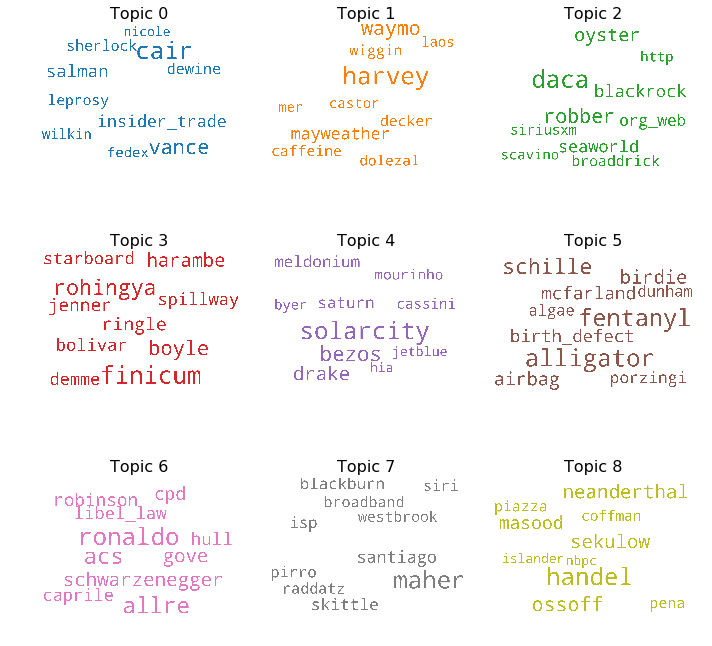

In [90]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

lda_model = lda_model_tfidf

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
df_dominant_topic_sub

TypeError: object of type 'float' has no len()

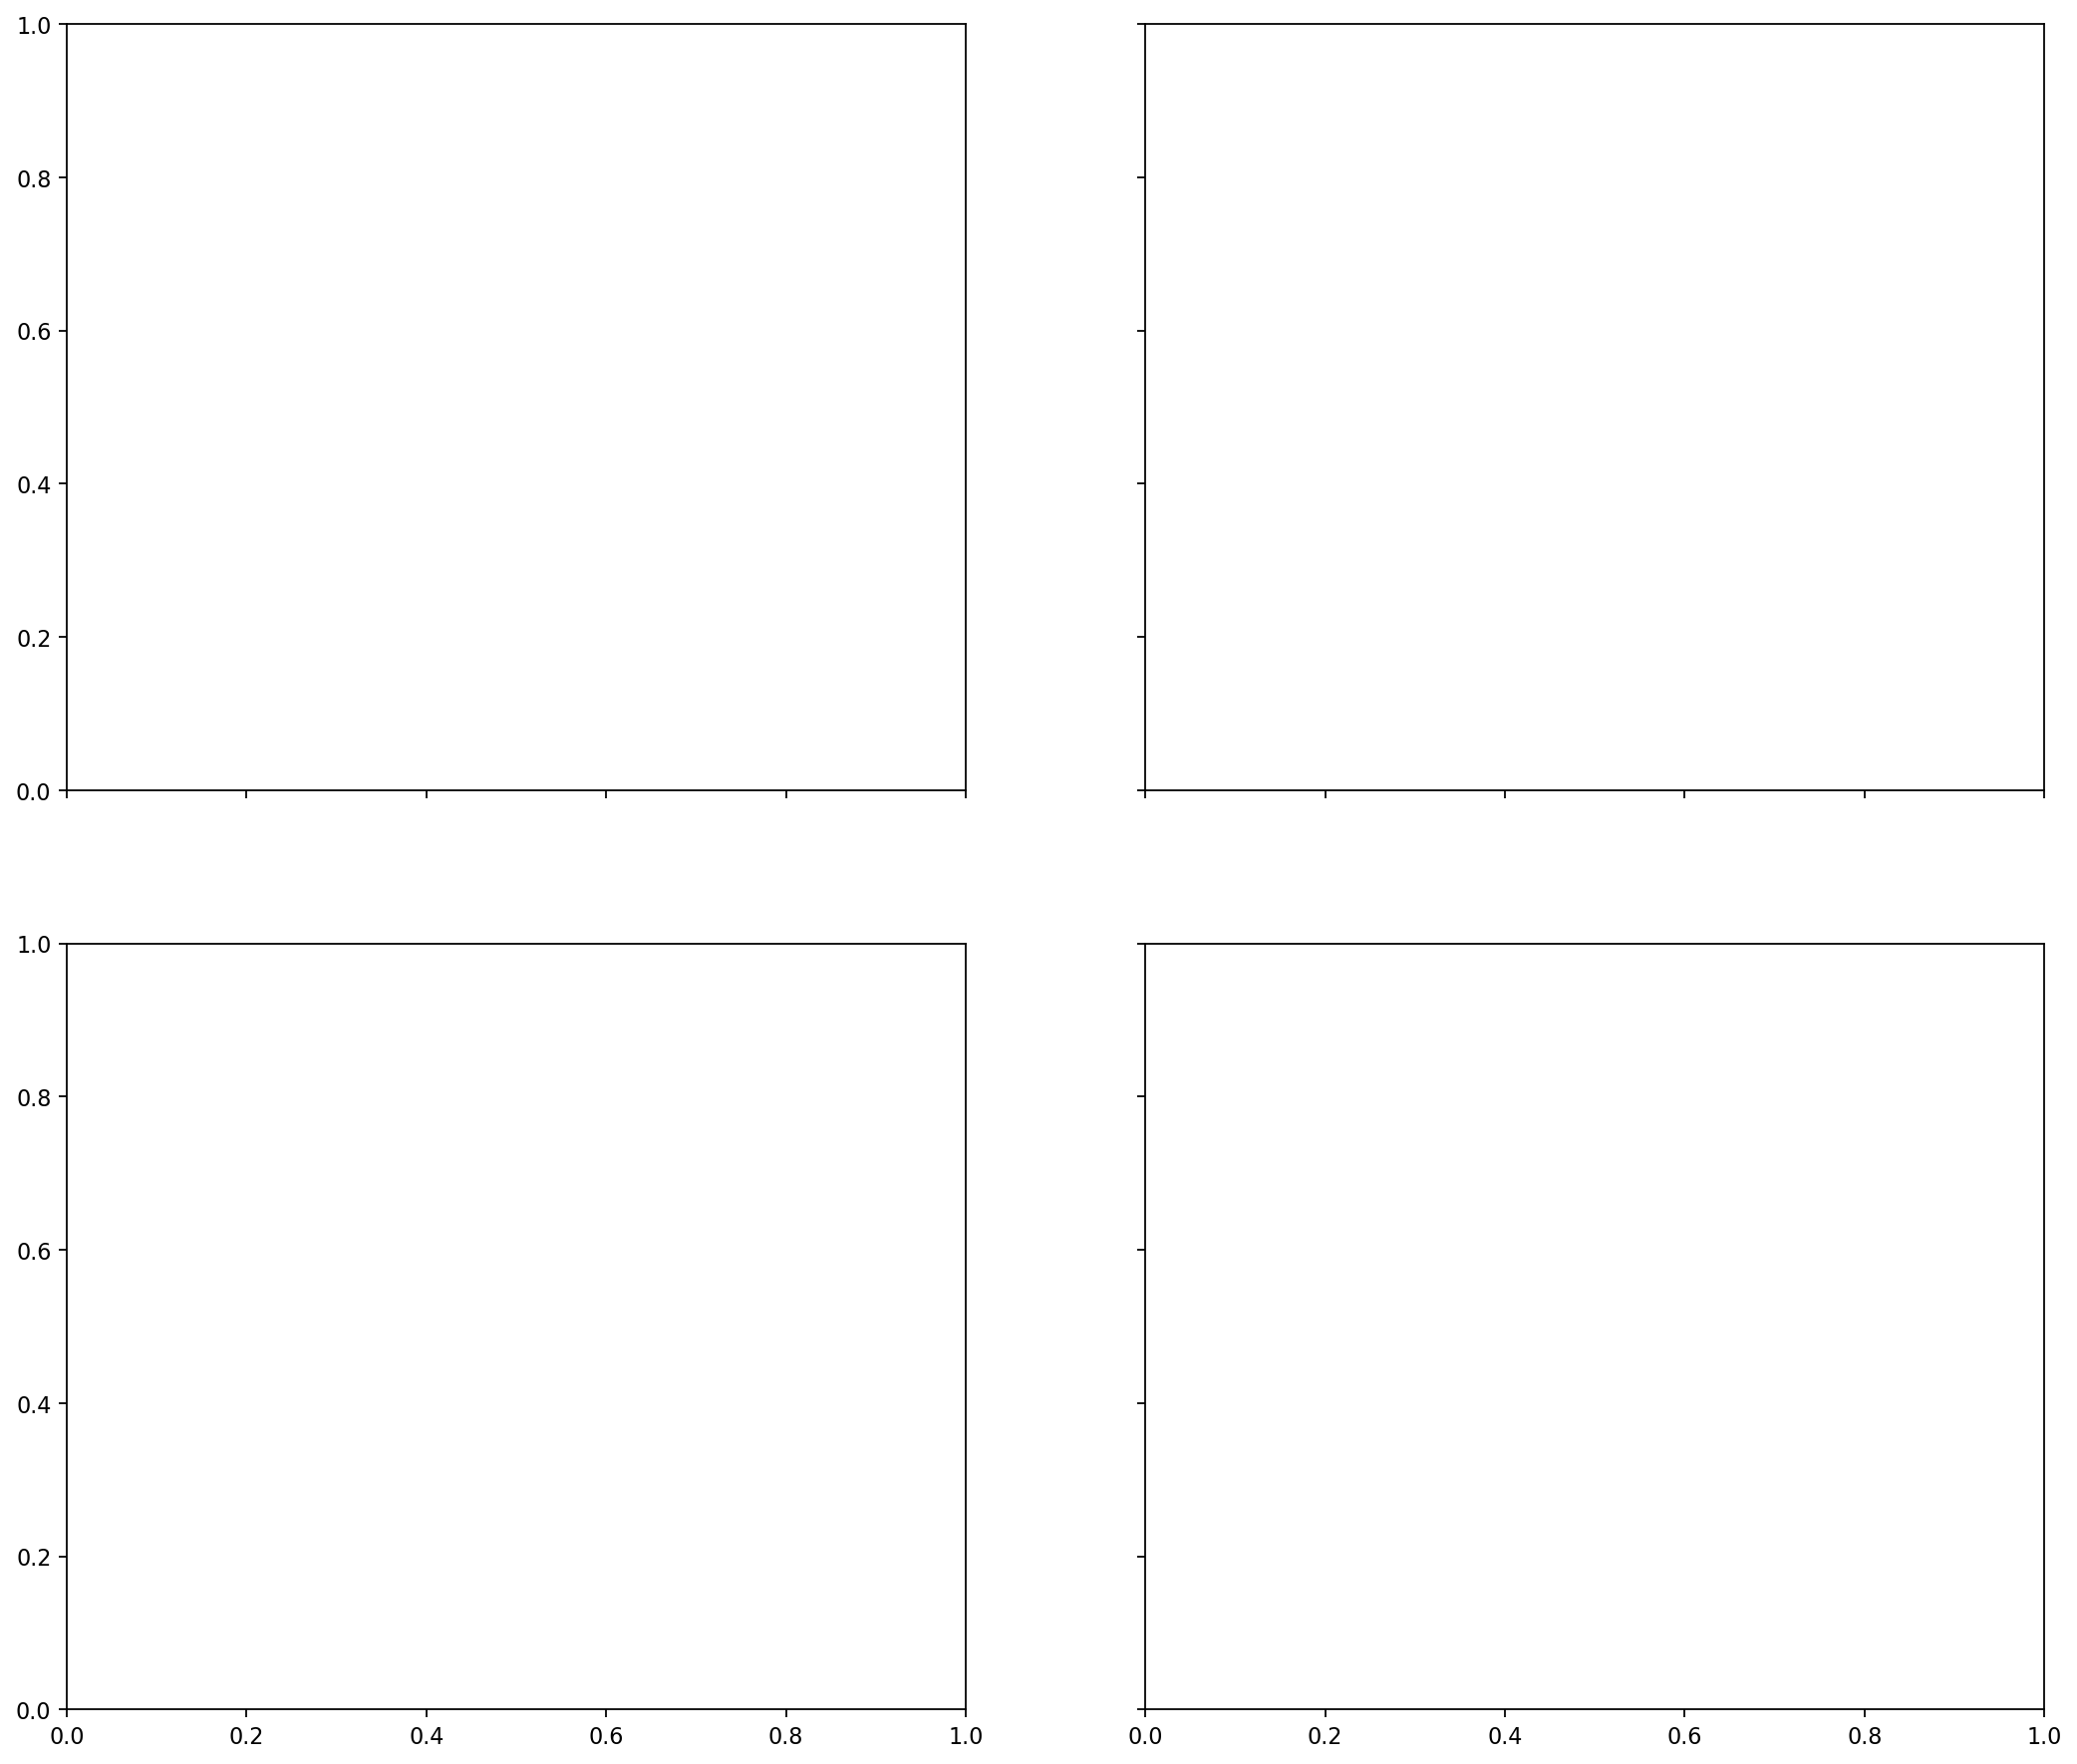

In [91]:

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [92]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus_tfidf))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.677091394183972

Coherence Score:  0.6435895135836791


In [93]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
vis

c:\users\jesper van stee\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
19    -0.429920 -0.021215       1        1  71.772881
17    -0.334716  0.145589       2        1   8.837335
13    -0.310268 -0.157775       3        1   7.285104
2     -0.022119  0.134881       4        1   2.251127
6      0.046228 -0.031752       5        1   1.320374
16     0.072262 -0.006393       6        1   0.599671
14     0.070648 -0.005720       7        1   0.586479
5      0.070151 -0.004855       8        1   0.580157
11     0.070748 -0.004749       9        1   0.575808
0      0.070379 -0.004702      10        1   0.573274
8      0.070403 -0.004537      11        1   0.571174
1      0.070378 -0.004572      12        1   0.567580
12     0.069921 -0.004552      13        1   0.566333
10     0.069902 -0.004537      14        1   0.565019
3      0.069654 -0.004393      15        1   0.560978
4      0.069308 -0.004203      16        1   0.559299
18     0.069405 -0.004053      17        1   0.558689
15     0.069351 -0.004004      18        1   0.558516
7      0.069196 -0.004148      19        1   0.555295
9      0.069090 -0.004308      20        1   0.554907, topic_info=      Category        Freq         Term       Total  loglift  logprob
476    Default  582.000000       police  582.000000  30.0000  30.0000
753    Default  651.000000      percent  651.000000  29.0000  29.0000
976    Default  318.000000         team  318.000000  28.0000  28.0000
36     Default  528.000000      company  528.000000  27.0000  27.0000
1732   Default  262.000000         game  262.000000  26.0000  26.0000
1656   Default  328.000000         play  328.000000  25.0000  25.0000
1532   Default  225.000000       season  225.000000  24.0000  24.0000
201    Default  485.000000       attack  485.000000  23.0000  23.0000
215    Default  384.000000      officer  384.000000  22.0000  22.0000
2165   Default  178.000000       player  178.000000  21.0000  21.0000
1185   Default  317.000000          win  317.000000  20.0000  20.0000
205    Default  356.000000         kill  356.000000  19.0000  19.0000
952    Default  268.000000       market  268.000000  18.0000  18.0000
120    Default  489.000000     official  489.000000  17.0000  17.0000
710    Default  463.000000          man  463.000000  16.0000  16.0000
150    Default  538.000000       report  538.000000  15.0000  15.0000
538    Default  323.000000     business  323.000000  14.0000  14.0000
3862   Default  192.000000        water  192.000000  13.0000  13.0000
2541   Default  152.000000        music  152.000000  12.0000  12.0000
1170   Default  314.000000     military  314.000000  11.0000  11.0000
436    Default  242.000000       arrest  242.000000  10.0000  10.0000
1019   Default  180.000000        final  180.000000   9.0000   9.0000
2186   Default  266.000000        shoot  266.000000   8.0000   8.0000
2119   Default  159.000000          fan  159.000000   7.0000   7.0000
1514   Default  383.000000         plan  383.000000   6.0000   6.0000
696    Default  363.000000          job  363.000000   5.0000   5.0000
1603   Default  116.000000       editor  116.000000   4.0000   4.0000
1325   Default  216.000000      economy  216.000000   3.0000   3.0000
1745   Default  210.000000        price  210.000000   2.0000   2.0000
751    Default  326.000000          pay  326.000000   1.0000   1.0000
...        ...         ...          ...         ...      ...      ...
43393  Topic20    2.245506    blackrock    2.827139   4.9638  -7.0259
37149  Topic20    2.184091     seaworld    2.765728   4.9580  -7.0536
39064  Topic20    1.924546      org_web    2.506179   4.9301  -7.1801
7733   Topic20    1.648543   broaddrick    2.230217   4.8919  -7.3349
20667  Topic20    1.471427     siriusxm    2.053570   4.8608  -7.4486
33561  Topic20    1.449899      scavino    2.031574   4.8568  -7.4633
13514  Topic20    1.445655         womb    2.027912   4.8557  -7.4662
38133  Topic20    1.374503     sinclair

# Part 2 Words embeddings

In [ ]:
# !python3 -m spacy download en_vectors_web_lg

In [ ]:
from keras.models import Model 
from keras.layers import Embedding, Dot, Flatten
class Word2Vec(Model):
  def __init__(self, vocab_size, embedding_dim, num_ns=5):
    super(Word2Vec, self).__init__()
    self.target_embedding = Embedding(vocab_size, 
                                      embedding_dim,
                                      input_length=1,
                                      name="w2v_embedding", )
    self.context_embedding = Embedding(vocab_size, 
                                       embedding_dim, 
                                       input_length=num_ns+1)
    self.dots = Dot(axes=(3,2))
    self.flatten = Flatten()

  def call(self, pair):
    target, context = pair
    we = self.target_embedding(target)
    ce = self.context_embedding(context)
    dots = self.dots([ce, we])
    return self.flatten(dots)

We only have to load the weights

In [ ]:
embedding_dim = 128
vocab_size = 4096
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
from keras.utils import plot_model
plot_model(word2vec)
# word2vec.load_weights('weights.h5')